In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
%matplotlib inline
plt.style.use('seaborn-white')

Here we are just dealing with Cu data

In [2]:
data = pd.ExcelFile('Data1/Cu.xlsx')
print(data.sheet_names)

['Sheet1', 'Sheet3', 'xS vs FeS domain']


In [3]:
df1 = data.parse('Sheet1')
df1.head(5)

,Reference,Run #,D(Cu),Dinv,LnFeDomains,LnDinv
0,NaN,IT10,0.43,2.325581,-0.063935,0.843970
1,3,IT11,0.32,3.125000,-0.171537,1.139434
2,Chabot 2008,IT14,0.33,3.030303,-0.297457,1.108663
3,"Fe-Ni-S, 1 atm",IT3,0.33,3.030303,-0.565593,1.108663
4,NaN,IT4,0.24,4.166667,-0.818951,1.427116


In [4]:
df2 = df1.drop(['Reference', 'Run #'], axis=1)
df2.dropna()
pd.options.display.max_rows = 999
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
D(Cu)          72 non-null float64
Dinv           72 non-null float64
LnFeDomains    72 non-null float64
LnDinv         72 non-null float64
dtypes: float64(4)
memory usage: 2.3 KB


,D(Cu),Dinv,LnFeDomains,LnDinv
0,0.43,2.325581,-0.063935,0.843970
1,0.32,3.125000,-0.171537,1.139434
2,0.33,3.030303,-0.297457,1.108663
3,0.33,3.030303,-0.565593,1.108663
4,0.24,4.166667,-0.818951,1.427116


In [5]:
df2['FeDomains'] = np.exp(df2['LnFeDomains'])
df2.head()

,D(Cu),Dinv,LnFeDomains,LnDinv,FeDomains
0,0.43,2.325581,-0.063935,0.843970,0.938066
1,0.32,3.125000,-0.171537,1.139434,0.842369
2,0.33,3.030303,-0.297457,1.108663,0.742704
3,0.33,3.030303,-0.565593,1.108663,0.568023
4,0.24,4.166667,-0.818951,1.427116,0.440894


**Assumption**: We have initially asssumed that all the non-metals have equal impact, and the concentration of Fe-domains is the only criteron on which the fractionation of elements depends.

Plotting Fe-Domains vs 1/D

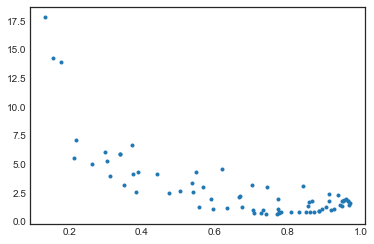

In [6]:
plt.plot(df2['FeDomains'],df2['Dinv'], marker='.', linestyle='none')
plt.show()

In [7]:
df2['Dinv'].min()

0.625

Dinv reaches its minimum value at aroud 7 and after that no point is below that, this curve looks more like a **hyperbola** than a linear , quadratic or logarithmic fit.

But if we **reject the Fe-S-C data** then even a linear model will give us a nice fit. Try this with qualitative variable introduction of different non-metals.

#### **(A)** Fitting a linear model

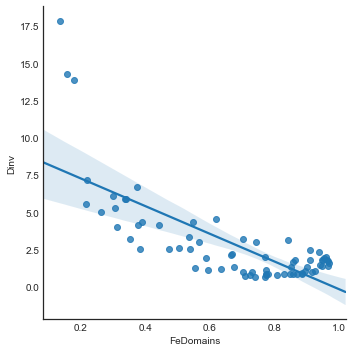

In [8]:
sns.lmplot(x='FeDomains', y='Dinv', data=df2)
plt.show()

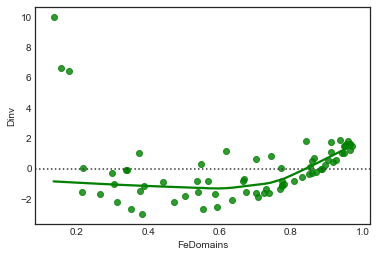

In [9]:
sns.residplot(x='FeDomains', y='Dinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

**Residual plots are tools to identify non-linearity of data. Ideally, residual plots show no discernible pattern but presence of a pattern may show problem with some aspect of linear model.**

**An important assumption of the linear regression model is that the error
terms, e1, e2, . . . , en, are uncorrelated. What does this mean? For instance,
if the errors are uncorrelated, then the fact that ei is positive provides
little or no information about the sign of ei+1.**

1) Here we can clearly see a little pattern in the values of residuals(1st problem)

2) The R^2 value of the fit is too low.

3) Even though there seems to be little **non-linearity in the response predictor relationship** but there is large **correlation in error terms**(2nd problem).

4) This residual plot seems to have constant variance.

Trying log, minus x2, square-root x to remove any pattern from the residual plot.

In [10]:
est = smf.ols('Dinv ~ FeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     84.07
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           1.30e-13
Time:                        22:43:55   Log-Likelihood:                -154.85
No. Observations:                  72   AIC:                             313.7
Df Residuals:                      70   BIC:                             318.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1166      0.723     12.616      0.000       7.675      10.558
FeDomains     -9.2683      1.011     -9.169      0.000     -11.284      -7.252
==============================================================================
Omnibus:                       52.668   Durbin-Watson:                   0.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.974
Skew:                           2.215   Prob(JB):                     8.52e-50
Kurtosis:                      10.463   Cond. No.                         5.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression model assumes that there is a straight-line relationship between the predictors and the response. If the true relationship is far from linear, then virtually all of the conclusions that we draw from the fit are suspect. In addition, the prediction accuracy of the model can be significantly reduced.
The nonlinearity in the regression plot and the poor R-squared value(~.54) tells us that linear model is not suitable for this data.

Degree 2 might do better!

### (B) Squared model

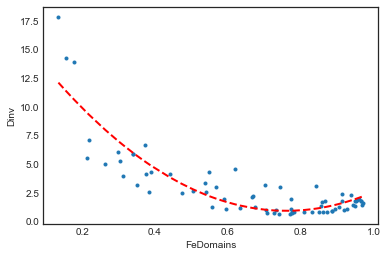

Function equation : 
        2
28.62 x - 43.5 x + 17.47


In [11]:
fit = np.polyfit(df2['FeDomains'],df2['Dinv'], 2)
fit_fn = np.poly1d(fit)

plt.plot(df2['FeDomains'],df2['Dinv'], '.', np.sort(df2['FeDomains']), fit_fn(np.sort(df2['FeDomains'])), '--r', linewidth=2)
plt.xlabel("FeDomains")
plt.ylabel("Dinv")
plt.show()
print('Function equation : \n',fit_fn)

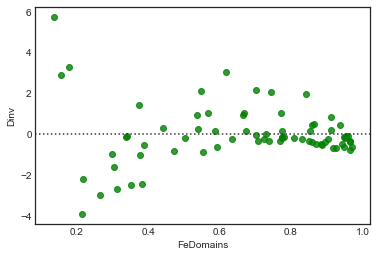

In [12]:
sns.residplot(x='FeDomains', y='Dinv', order = 2,data=df2, color='green')
plt.show()

The residual plot makes us clear the non-linearity of the data in the squared model above.

**IF WE COULD JUST IGNORE THE THREE POINTS** at the top then the rest of the data fits the linear model just fine. While, on changing the degree to 2 other than the 3 points on the top, rest of the model resists the degree 2 model.

However, this time we get a higher Rsquared value (~.78), than the linear model. But this is due to the fact that the earlier linear model was distorted too much by the outlier values of the Fe-S-C data.

1) Clear patterns in residuals, non-linearity of the response-predictor relationship

2)R^2 is decent

3)Significant correlation in error terms

4)Heteroscedasticity present

In [13]:
est = smf.ols('Dinv ~ FeDomains + np.square(FeDomains)', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     125.9
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           9.48e-24
Time:                        22:43:56   Log-Likelihood:                -127.94
No. Observations:                  72   AIC:                             261.9
Df Residuals:                      69   BIC:                             268.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               17.4690      1.077     16.220      0.000      15.320      19.618
FeDomains              -43.5000      3.970    -10.957      0.000     -51.420     -35.580
np.square(FeDomains)    28.6214      3.267      8.760      0.000      22.103      35.140
==============================================================================
Omnibus:                       18.583   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.610
Skew:                           0.792   Prob(JB):                     9.22e-10
Kurtosis:                       6.371   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

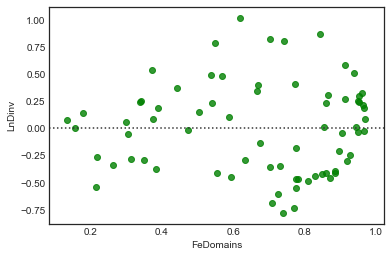

In [14]:
sns.residplot(x='FeDomains', y='LnDinv', order = 2,data=df2, color='green')
plt.show()

Heteroscedasticity definately reduced

In [15]:
est = smf.ols('LnDinv ~ FeDomains + np.square(FeDomains)', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     86.91
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           1.40e-19
Time:                        22:43:56   Log-Likelihood:                -38.712
No. Observations:                  72   AIC:                             83.42
Df Residuals:                      69   BIC:                             90.25
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.8849      0.312     12.455      0.000       3.263       4.507
FeDomains               -8.7447      1.150     -7.606      0.000     -11.038      -6.451
np.square(FeDomains)     5.2856      0.946      5.586      0.000       3.398       7.173
==============================================================================
Omnibus:                        2.319   Durbin-Watson:                   0.627
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                2.003
Skew:                           0.289   Prob(JB):                        0.367
Kurtosis:                       2.422   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

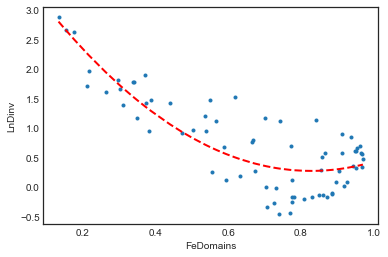

Function equation : 
        2
5.286 x - 8.745 x + 3.885


In [16]:
fit = np.polyfit(df2['FeDomains'],df2['LnDinv'], 2)
fit_fn = np.poly1d(fit)

plt.plot(df2['FeDomains'],df2['LnDinv'], '.', np.sort(df2['FeDomains']), fit_fn(np.sort(df2['FeDomains'])), '--r', linewidth=2)
plt.xlabel("FeDomains")
plt.ylabel("LnDinv")
plt.show()
print('Function equation : \n',fit_fn)

1) Non-linearity in predictor-response relationship has definately reduced

2) R2 reduced a bit, but still acceptable.

3)No clear correlation present in error terms

4)Looks homoscedastic

This fit seems good, but a problem with squared model is that its value decreases, reaches a minimum and then again increases. Here(in case of Cu) it reaches its minimum close to 0.85, and after that it increases, but in some other element we might have that minimum close to 0.5, which may cause some problem.

The doubt is that our equation suggest that the LnDinv will have a minimum at some point and will increase both sides from that point. But chemically on increasing the concentration of Fe,(for siderophile elements) the value Dinv should only decrease.

**Now even if our domain lies between 0 and 1 and our minimum is close to 1, does this fit actually represent the predictor-response relationship correctly?**

No, I don't think so!

### (C) Trying Square-root of x

Now rather than fitting a square-root line to the data, we are fitting a straight line to the squared data.

Now, this is a bit unintuitive, the reason is that np.polyfit works only with integer values

In [17]:
df2.head()

,D(Cu),Dinv,LnFeDomains,LnDinv,FeDomains
0,0.43,2.325581,-0.063935,0.843970,0.938066
1,0.32,3.125000,-0.171537,1.139434,0.842369
2,0.33,3.030303,-0.297457,1.108663,0.742704
3,0.33,3.030303,-0.565593,1.108663,0.568023
4,0.24,4.166667,-0.818951,1.427116,0.440894


In [18]:
df2['sqrtFeDomains'] = np.sqrt(df2['FeDomains'])
df2['OneMinusFeD'] = np.subtract(1,df2['FeDomains'])
df2.head()

,D(Cu),Dinv,LnFeDomains,LnDinv,FeDomains,sqrtFeDomains,OneMinusFeD
0,0.43,2.325581,-0.063935,0.843970,0.938066,0.968538,0.061934
1,0.32,3.125000,-0.171537,1.139434,0.842369,0.917807,0.157631
2,0.33,3.030303,-0.297457,1.108663,0.742704,0.861803,0.257296
3,0.33,3.030303,-0.565593,1.108663,0.568023,0.753673,0.431977
4,0.24,4.166667,-0.818951,1.427116,0.440894,0.663998,0.559106


In [19]:
## ya! this doesn't work, just gives a stright line
## So, we need to plot a regressio w/o a library or just a st-line on the square-rooted data
## Taking the square root seems much more convinient than writing the code w/o any library !! 

# fit = np.polyfit(df2['FeDomains'],df2['Dinv'], 0.5)
# fit_fn = np.poly1d(fit)

# plt.plot(df2['FeDomains'],df2['Dinv'], '.', np.sort(df2['FeDomains']), fit_fn(np.sort(df2['FeDomains'])), '--r', linewidth=2)
# plt.xlabel("FeDomains")
# plt.ylabel("Dinv")
# plt.show()

In [20]:
est = smf.ols('Dinv ~ FeDomains + sqrtFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     184.2
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           2.14e-28
Time:                        22:43:57   Log-Likelihood:                -116.77
No. Observations:                  72   AIC:                             239.5
Df Residuals:                      69   BIC:                             246.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        40.4117      2.781     14.532      0.000      34.864      45.959
FeDomains        52.3154      5.440      9.617      0.000      41.463      63.168
sqrtFeDomains   -90.5812      7.953    -11.390      0.000    -106.447     -74.716
==============================================================================
Omnibus:                        7.058   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.029   Jarque-Bera (JB):               12.746
Skew:                           0.083   Prob(JB):                      0.00171
Kurtosis:                       5.055   Cond. No.                         99.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

regr_coeff : [ 52.31543059 -90.58121186]
regr_intercept : 40.41165509917685
regr_score : 0.8422477831659844


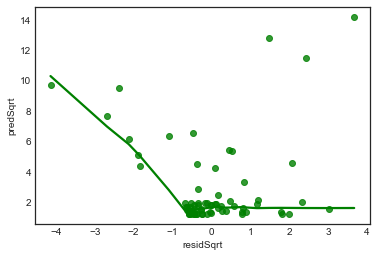

In [21]:
regr = skl_lm.LinearRegression()

# Linear fit
Xsqrt = df2[['FeDomains','sqrtFeDomains']].values
ysqrt = df2['Dinv']
regr.fit(Xsqrt, ysqrt)
print('regr_coeff :',regr.coef_)
print('regr_intercept :',regr.intercept_)
print('regr_score :',regr.score(Xsqrt,ysqrt))

df2['predSqrt'] = regr.predict(Xsqrt)
df2['residSqrt'] = df2.Dinv - df2.predSqrt

sns.regplot(df2['residSqrt'],df2['predSqrt'], lowess=True, color='green')

Now, the sqrt model is definately **rejected** with this much non-linearity in the relationship.

### (D) Trying log of x

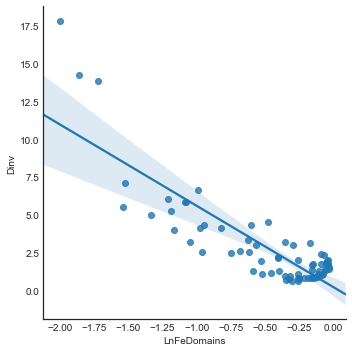

In [22]:
sns.lmplot(x='LnFeDomains', y='Dinv', data=df2)
plt.show()

In [23]:
est = smf.ols('Dinv ~ LnFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     181.3
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           4.13e-21
Time:                        22:43:58   Log-Likelihood:                -137.24
No. Observations:                  72   AIC:                             278.5
Df Residuals:                      70   BIC:                             283.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2343      0.277      0.845      0.401      -0.319       0.787
LnFeDomains    -5.3741      0.399    -13.466      0.000      -6.170      -4.578
==============================================================================
Omnibus:                       26.178   Durbin-Watson:                   0.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.571
Skew:                           1.222   Prob(JB):                     1.41e-12
Kurtosis:                       6.495   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Significant p-value of the intercept.**

### Learn how to deal with high p-value ~~~

This might be due to the high levarage points.

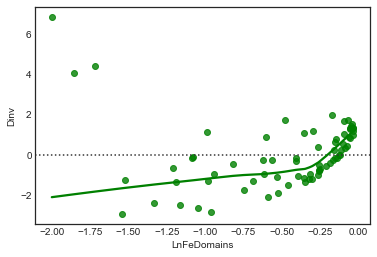

In [24]:
sns.residplot(x='LnFeDomains', y='Dinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

Here the regression line of the residual plot looks better than the squared model(B). The residual curve for the linear model(A) might look better than model(D) at first glance but model(A) has a different axis than this(D) and actually that one(A) is very similar to this one. But this might also be due to outliers. W/o the outliers the regression plot of residuals of model(D) will be worse.

This fit suffers from heteroscedasticity

1) PR relationship seems to be linear

2) R2 is decent

3)Error terms are correlated.

4)Sort-of heteroscedastic

**Taking log of response to remove heteroscedasticity**

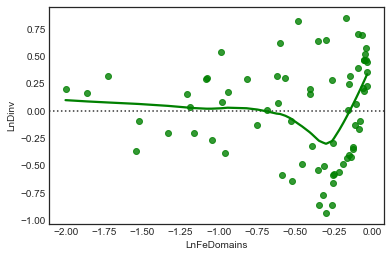

In [25]:
sns.residplot(x='LnFeDomains', y='LnDinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

Can't comment on heteroscedasticty, on this curve, this might just be because of too few data points.

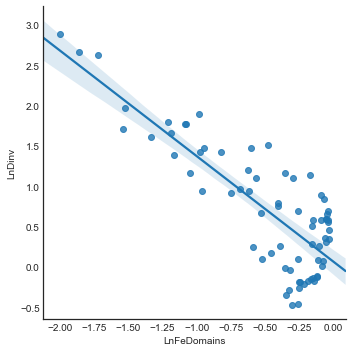

In [26]:
sns.lmplot(x='LnFeDomains', y='LnDinv', data=df2)
plt.show()

Now this definately looks a better fit than its predecessor

In [27]:
est = smf.ols('LnDinv ~ LnFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           1.54e-18
Time:                        22:43:59   Log-Likelihood:                -44.046
No. Observations:                  72   AIC:                             92.09
Df Residuals:                      70   BIC:                             96.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0696      0.076      0.916      0.363      -0.082       0.221
LnFeDomains    -1.3054      0.109    -11.934      0.000      -1.524      -1.087
==============================================================================
Omnibus:                        6.467   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                2.802
Skew:                          -0.163   Prob(JB):                        0.246
Kurtosis:                       2.090   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Surprisingly, the value of **r2 has decreased.** Also there is a **significant p-value of the intercept.**

**NEED TO DEAL WITH THE INTERCEPT TERM**

### (E) Checking for hyperbola

In [28]:
df2['FeDomainsInv'] = np.reciprocal(df2['FeDomains'])
df2.head()

,D(Cu),Dinv,LnFeDomains,LnDinv,FeDomains,sqrtFeDomains,OneMinusFeD,predSqrt,residSqrt,FeDomainsInv
0,0.43,2.325581,-0.063935,0.843970,0.938066,0.968538,0.061934,1.755631,0.569950,1.066023
1,0.32,3.125000,-0.171537,1.139434,0.842369,0.917807,0.157631,1.344516,1.780484,1.187128
2,0.33,3.030303,-0.297457,1.108663,0.742704,0.861803,0.257296,1.203396,1.826907,1.346431
3,0.33,3.030303,-0.565593,1.108663,0.568023,0.753673,0.431977,1.859406,1.170897,1.760491
4,0.24,4.166667,-0.818951,1.427116,0.440894,0.663998,0.559106,3.331429,0.835238,2.268120


popt:  [ 2.25439987 -1.37874726]
pcov:  [[ 0.01133316 -0.02148365]
 [-0.02148365  0.05907179]]


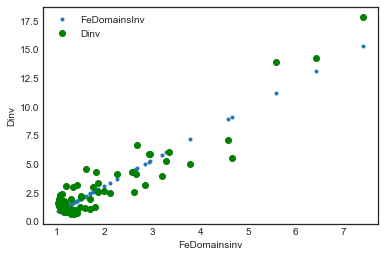

In [29]:
def hyperbola(t,a,b):
    return a*t + b

popt, pcov = curve_fit(hyperbola, df2['FeDomainsInv'], df2['Dinv'])

print('popt: ',popt)
print('pcov: ',pcov)


plt.plot(df2['FeDomainsInv'], hyperbola(df2['FeDomainsInv'], *popt), '.', )

plt.plot(df2['FeDomainsInv'],df2['Dinv'], marker='o', linestyle='none',  color='green')

plt.xlabel('FeDomainsinv')
plt.ylabel('Dinv')
plt.legend()
plt.show()

In [30]:
est = smf.ols('Dinv ~ FeDomainsInv', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     448.4
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           3.73e-32
Time:                        22:43:59   Log-Likelihood:                -111.17
No. Observations:                  72   AIC:                             226.3
Df Residuals:                      70   BIC:                             230.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3787      0.243     -5.673      0.000      -1.863      -0.894
FeDomainsInv     2.2544      0.106     21.177      0.000       2.042       2.467
==============================================================================
Omnibus:                        1.829   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.172
Skew:                          -0.126   Prob(JB):                        0.557
Kurtosis:                       3.572   Cond. No.                         4.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

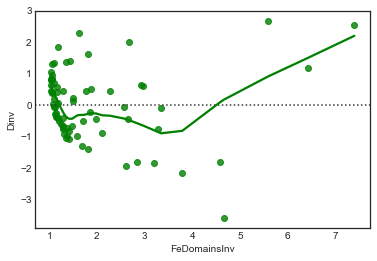

In [31]:
sns.residplot(x='FeDomainsInv', y='Dinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

Value of R^2 has also increased significantly.

**heteroscedastic**

Introducing LnDinv to deal with heteroscedasticity

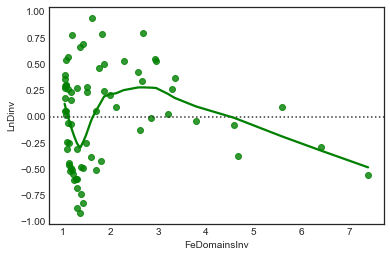

In [32]:
sns.residplot(x='FeDomainsInv', y='LnDinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

Non-linearity in the PR relationship visible

popt:  [ 0.49400187 -0.22060662]
pcov:  [[ 0.0018433  -0.00349425]
 [-0.00349425  0.00960785]]


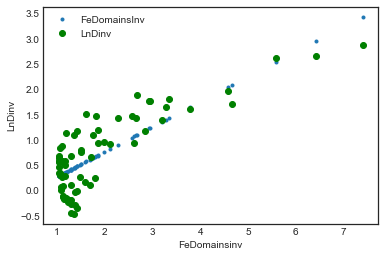

In [33]:
popt, pcov = curve_fit(hyperbola, df2['FeDomainsInv'], df2['LnDinv'])

print('popt: ',popt)
print('pcov: ',pcov)


plt.plot(df2['FeDomainsInv'], hyperbola(df2['FeDomainsInv'], *popt), '.', )

plt.plot(df2['FeDomainsInv'],df2['LnDinv'], marker='o', linestyle='none',  color='green')

plt.xlabel('FeDomainsinv')
plt.ylabel('LnDinv')
plt.legend()
plt.show()

In [34]:
est = smf.ols('LnDinv ~ FeDomainsInv', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     132.4
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           8.48e-18
Time:                        22:44:00   Log-Likelihood:                -45.788
No. Observations:                  72   AIC:                             95.58
Df Residuals:                      70   BIC:                             100.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2206      0.098     -2.251      0.028      -0.416      -0.025
FeDomainsInv     0.4940      0.043     11.506      0.000       0.408       0.580
==============================================================================
Omnibus:                        7.380   Durbin-Watson:                   0.416
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                2.787
Skew:                          -0.074   Prob(JB):                        0.248
Kurtosis:                       2.048   Cond. No.                         4.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The value of r2 decreased a lot.

#########################################################################

### Dealing with high leverage points

### Removed the 3 data points from the Fe-S-C system

If we believe that an outlier has occurred due to an error in data collection
or recording, then one solution is to simply remove the observation.
However, care should be taken, since an outlier may instead indicate a
deficiency with the model, such as a **missing predictor**.

In [35]:
data2 = pd.ExcelFile('ModifiedData/Cu_S-C_del.xlsx')
print(data.sheet_names)
df3 = data2.parse('Sheet1')
df3.head(5)

df4 = df3.drop(['Reference', 'Run #', 'D(Cu)'], axis=1)
df4.dropna()
pd.options.display.max_rows = 999
df4.info()

df4['FeDomains'] = np.exp(df4['LnFeDomains'])
df4['squaredFeDomains'] = np.square(df4['FeDomains'])

# df4= pd.DataFrame(dict(color=color))
# colors = {'1':'red', '2':'blue', '3':'green', '6':'black'}
# plt.plot(df4['FeDomains'],df4['Dinv'], marker='.', linestyle='none', c=df4['Fe-Ni-X'].apply(lambda x: colors[x]))

plt.show()
df4.head(69)

['Sheet1', 'Sheet3', 'xS vs FeS domain']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 4 columns):
Dinv           69 non-null float64
LnFeDomains    69 non-null float64
LnDinv         69 non-null float64
FeNiX          69 non-null int64
dtypes: float64(3), int64(1)
memory usage: 2.2 KB


,Dinv,LnFeDomains,LnDinv,FeNiX,FeDomains,squaredFeDomains
0,2.325581,-0.063935,0.843970,1,0.938066,0.879968
1,3.125000,-0.171537,1.139434,1,0.842369,0.709586
2,3.030303,-0.297457,1.108663,1,0.742704,0.551610
3,3.030303,-0.565593,1.108663,1,0.568023,0.322650
4,4.166667,-0.818951,1.427116,1,0.440894,0.194387
5,4.166667,-0.977994,1.427116,1,0.376065,0.141425
6,5.555556,-1.540667,1.714798,1,0.214238,0.045898
7,7.142857,-1.522616,1.966113,1,0.218141,0.047585
8,6.060606,-1.208104,1.801810,1,0.298763,0.089259
9,4.347826,-0.943130,1.469676,1,0.389407,0.151638


**(A1) Linear**

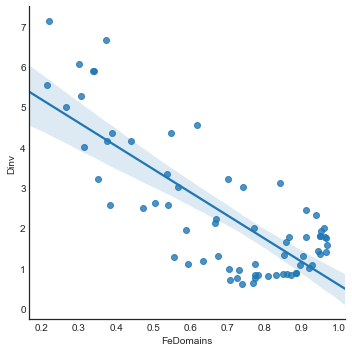

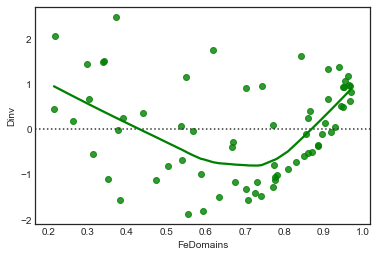

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     104.0
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           2.90e-15
Time:                        22:44:01   Log-Likelihood:                -100.56
No. Observations:                  69   AIC:                             205.1
Df Residuals:                      67   BIC:                             209.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3292      0.410     15.435      0.000       5.511       7.148
FeDomains     -5.7314      0.562    -10.197      0.000      -6.853      -4.609
==============================================================================
Omnibus:                        4.830   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                2.382
Skew:                           0.159   Prob(JB):                        0.304
Kurtosis:                       2.147   Cond. No.                         6.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
sns.lmplot(x='FeDomains', y='Dinv', data=df4)
plt.show()
sns.residplot(x='FeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()
est = smf.ols('Dinv ~ FeDomains', df4).fit()
est.summary()

Non-linearity in the data is clearly visible here. And can not comment on heteroscedasticity
**Checking with LnDinv**

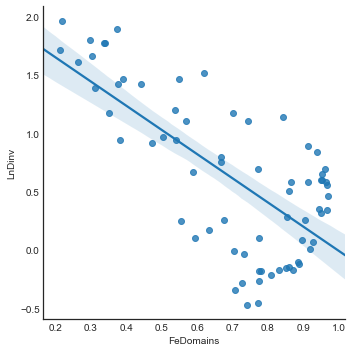

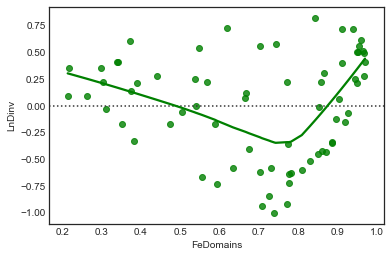

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     64.66
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           2.03e-11
Time:                        22:44:02   Log-Likelihood:                -46.793
No. Observations:                  69   AIC:                             97.59
Df Residuals:                      67   BIC:                             102.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0670      0.188     10.987      0.000       1.691       2.442
FeDomains     -2.0737      0.258     -8.041      0.000      -2.588      -1.559
==============================================================================
Omnibus:                        8.568   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                3.852
Skew:                          -0.321   Prob(JB):                        0.146
Kurtosis:                       2.036   Cond. No.                         6.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
sns.lmplot(x='FeDomains', y='LnDinv', data=df4)
plt.show()
sns.residplot(x='FeDomains', y='LnDinv', lowess=True, order = 1,data=df4, color='green')
plt.show()
est = smf.ols('LnDinv ~ FeDomains', df4).fit()
est.summary()

r2 is unacceptable >>> **rejected**

**(A2) Squared**

In [38]:
# fit = np.polyfit(df4['FeDomains'],df4['Dinv'], 2)
# fit_fn = np.poly1d(fit)

# plt.plot(df4['FeDomains'],df4['Dinv'], '.', np.sort(df4['FeDomains']), fit_fn(np.sort(df4['FeDomains'])), '--r', linewidth=2)
# plt.xlabel("FeDomains")
# plt.ylabel("Dinv")
# plt.show()
# print('Function equation : \n',fit_fn)

# sns.residplot(x='squaredFeDomains', y='Dinv',lowess=True, order = 1,data=df4, color='green')
# plt.show()

## This thing fucks up, I don't know why, gives a st line in the residual plot.

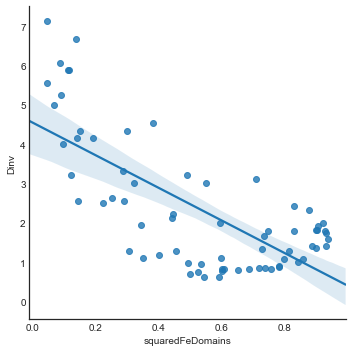

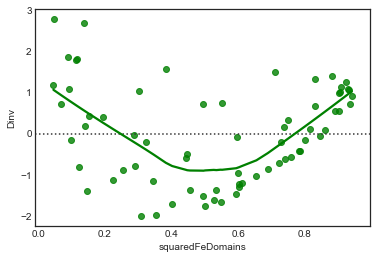

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     91.81
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           8.60e-20
Time:                        22:44:02   Log-Likelihood:                -86.980
No. Observations:                  69   AIC:                             180.0
Df Residuals:                      66   BIC:                             186.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.8787      0.875     12.433      0.000       9.132      12.626
FeDomains          -22.5945      3.025     -7.469      0.000     -28.635     -16.554
squaredFeDomains    13.4313      2.381      5.641      0.000       8.678      18.185
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.470
Skew:                           0.814   Prob(JB):                       0.0145
Kurtosis:                       3.545   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
sns.lmplot(x='squaredFeDomains', y='Dinv', data=df4)
plt.show()
sns.residplot(x='squaredFeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()
est = smf.ols('Dinv ~ FeDomains + squaredFeDomains', df4).fit()
est.summary()

This one is again indicating non-linearity.

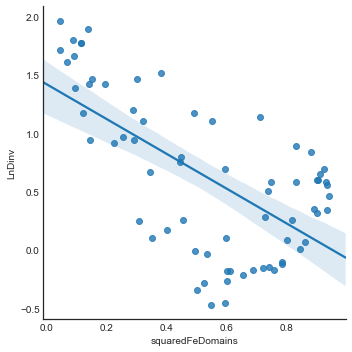

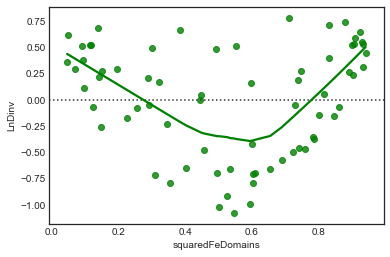

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     49.59
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           7.12e-14
Time:                        22:44:03   Log-Likelihood:                -38.450
No. Observations:                  69   AIC:                             82.90
Df Residuals:                      66   BIC:                             89.60
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.7631      0.433      8.690      0.000       2.898       4.628
FeDomains           -8.3605      1.497     -5.584      0.000     -11.350      -5.371
squaredFeDomains     5.0074      1.178      4.249      0.000       2.655       7.360
==============================================================================
Omnibus:                        2.944   Durbin-Watson:                   0.545
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                2.156
Skew:                           0.265   Prob(JB):                        0.340
Kurtosis:                       2.315   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
sns.lmplot(x='squaredFeDomains', y='LnDinv', data=df4)
plt.show()
sns.residplot(x='squaredFeDomains', y='LnDinv', lowess=True, order = 1,data=df4, color='green')
plt.show()
est = smf.ols('LnDinv ~ FeDomains + squaredFeDomains', df4).fit()
est.summary()

Taking log(y) made no impact on the non-linear rel^n of Predictor and response.

**(A3) LOG**

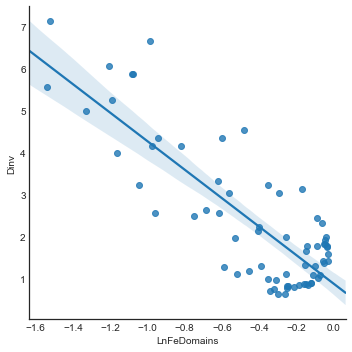

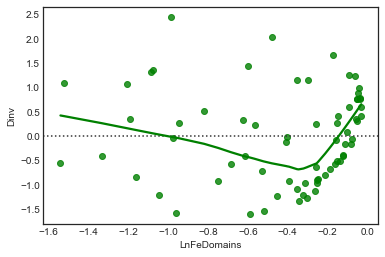

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     143.6
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           2.56e-18
Time:                        22:44:03   Log-Likelihood:                -93.369
No. Observations:                  69   AIC:                             190.7
Df Residuals:                      67   BIC:                             195.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8732      0.168      5.186      0.000       0.537       1.209
LnFeDomains    -3.3978      0.284    -11.982      0.000      -3.964      -2.832
==============================================================================
Omnibus:                        2.763   Durbin-Watson:                   0.663
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.252
Skew:                           0.311   Prob(JB):                        0.324
Kurtosis:                       2.371   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
sns.lmplot(x='LnFeDomains', y='Dinv', data=df4)
plt.show()
sns.residplot(x='LnFeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()
est = smf.ols('Dinv ~ LnFeDomains', df4).fit()
est.summary()

Non-linearity in the PR relationship, heteroscedasticity present

**p-value is significant after removing the high leverage points.**

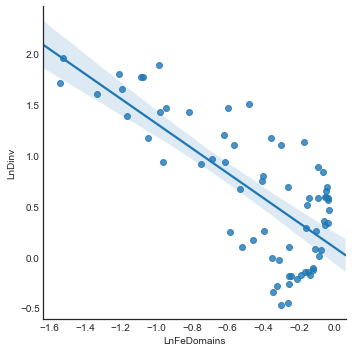

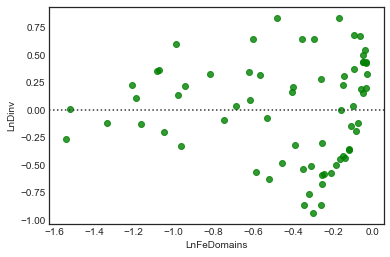

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     79.68
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           5.19e-13
Time:                        22:44:04   Log-Likelihood:                -43.068
No. Observations:                  69   AIC:                             90.14
Df Residuals:                      67   BIC:                             94.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0966      0.081      1.189      0.239      -0.066       0.259
LnFeDomains    -1.2210      0.137     -8.926      0.000      -1.494      -0.948
==============================================================================
Omnibus:                        6.971   Durbin-Watson:                   0.416
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                2.869
Skew:                          -0.166   Prob(JB):                        0.238
Kurtosis:                       2.058   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
sns.lmplot(x='LnFeDomains', y='LnDinv', data=df4)
plt.show()
sns.residplot(x='LnFeDomains', y='LnDinv', order = 1,data=df4, color='green')
plt.show()
est = smf.ols('LnDinv ~ LnFeDomains', df4).fit()
est.summary()

PR Relationship seems to be linear. Can't comment on heteroscedasticity. And r2 decreased too much.

**p-value of the intercept is again insignificant**. R2 value of the fit has decreased too much. Need to deal with the intercept / or the p-value

**(A4) Hyperbola**

popt:  [ 1.63608881 -0.42237708]
pcov:  [[ 0.01755015 -0.02977684]
 [-0.02977684  0.0630737 ]]


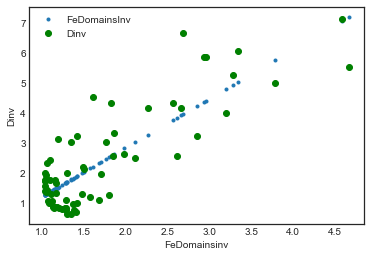

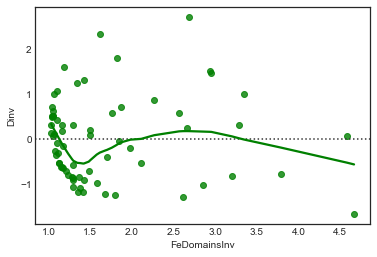

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     152.5
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           6.27e-19
Time:                        22:44:04   Log-Likelihood:                -91.932
No. Observations:                  69   AIC:                             187.9
Df Residuals:                      67   BIC:                             192.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.4224      0.251     -1.682      0.097      -0.924       0.079
FeDomainsInv     1.6361      0.132     12.350      0.000       1.372       1.901
==============================================================================
Omnibus:                        5.033   Durbin-Watson:                   0.743
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                4.646
Skew:                           0.635   Prob(JB):                       0.0980
Kurtosis:                       3.045   Cond. No.                         5.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
df4['FeDomainsInv'] = np.reciprocal(df4['FeDomains'])
df4.head()

def hyperbola(t,a,b):
    return a*t + b

popt, pcov = curve_fit(hyperbola, df4['FeDomainsInv'], df4['Dinv'])

print('popt: ',popt)
print('pcov: ',pcov)


plt.plot(df4['FeDomainsInv'], hyperbola(df4['FeDomainsInv'], *popt), '.', )

plt.plot(df4['FeDomainsInv'],df4['Dinv'], marker='o', linestyle='none',  color='green')

plt.xlabel('FeDomainsinv')
plt.ylabel('Dinv')
plt.legend()
plt.show()

sns.residplot(x='FeDomainsInv', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()

est = smf.ols('Dinv ~ FeDomainsInv', df4).fit()
est.summary()

popt:  [ 0.57899653 -0.35384341]
pcov:  [[ 0.00431707 -0.00732465]
 [-0.00732465  0.01551517]]


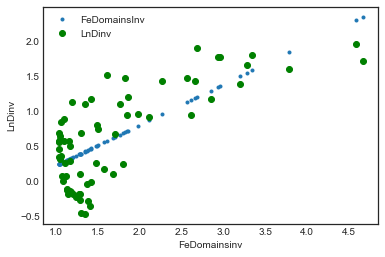

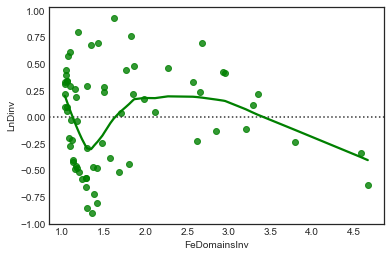

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     77.65
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           8.31e-13
Time:                        22:44:05   Log-Likelihood:                -43.547
No. Observations:                  69   AIC:                             91.09
Df Residuals:                      67   BIC:                             95.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3538      0.125     -2.841      0.006      -0.602      -0.105
FeDomainsInv     0.5790      0.066      8.812      0.000       0.448       0.710
==============================================================================
Omnibus:                        8.082   Durbin-Watson:                   0.455
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                2.858
Skew:                          -0.062   Prob(JB):                        0.240
Kurtosis:                       2.011   Cond. No.                         5.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
popt4, pcov4 = curve_fit(hyperbola, df4['FeDomainsInv'], df4['LnDinv'])

print('popt: ',popt4)
print('pcov: ',pcov4)


plt.plot(df4['FeDomainsInv'], hyperbola(df4['FeDomainsInv'], *popt4), '.', )

plt.plot(df4['FeDomainsInv'],df4['LnDinv'], marker='o', linestyle='none',  color='green')

plt.xlabel('FeDomainsinv')
plt.ylabel('LnDinv')
plt.legend()
plt.show()

sns.residplot(x='FeDomainsInv', y='LnDinv', lowess=True, order = 1,data=df4, color='green')
plt.show()

est = smf.ols('LnDinv ~ FeDomainsInv', df4).fit()
est.summary()


Ahhhhh!!!!!!! shit! 

hyperbola model seems to be working only with those outliers, r2 decreased to almost half,plus non-linearity in the PR relationship is also sighted with uncommentable heteroscedasticity.

**Summary:**

## Replicating the research paper

Plotting Ln(Fe-domains) vs Ln(1/D)

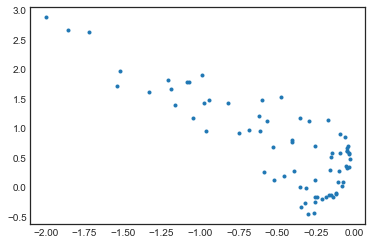

In [45]:
plt.plot(df2['LnFeDomains'],df2['LnDinv'], marker='.', linestyle='none')
plt.show()

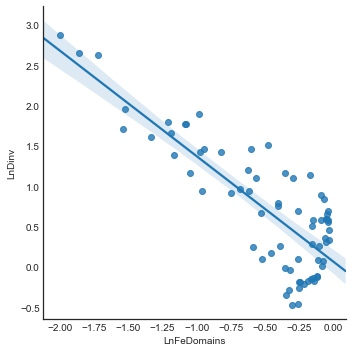

In [46]:
sns.lmplot(x='LnFeDomains', y='LnDinv', data=df2)
plt.show()

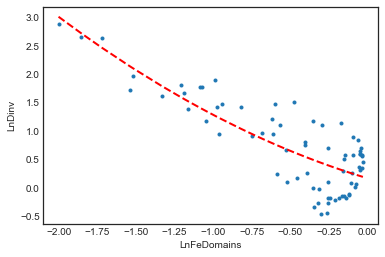

In [47]:
fit = np.polyfit(df2['LnFeDomains'],df2['LnDinv'], 2)
fit_fn = np.poly1d(fit)

plt.plot(df2['LnFeDomains'],df2['LnDinv'], '.', np.sort(df2['LnFeDomains']), fit_fn(np.sort(df2['LnFeDomains'])), '--r', linewidth=2)
plt.xlabel("LnFeDomains")
plt.ylabel("LnDinv")
plt.show()

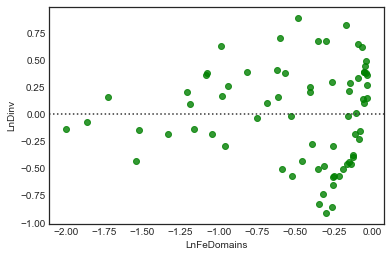

In [48]:
sns.residplot(x='LnFeDomains', y='LnDinv', order = 2,data=df2, color='green')
plt.show()

Residual plots are tools to identify non-linearity of data. Ideally, residual plots show no discernible pattern but presence of a pattern may show problem with some aspect of linear model. 
Here we can clearly see that as the concentration of Fe domains increases the spread 
This data is suffering from **heteroscedasticity**

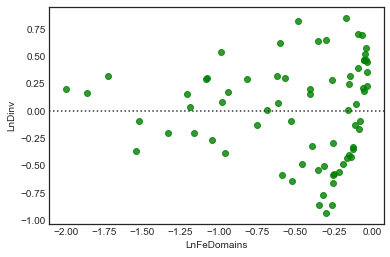

In [49]:
sns.residplot(x='LnFeDomains', y='LnDinv', order = 1,data=df2, color='green')
plt.show()

In [50]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(df2['LnFeDomains'], with_mean=True, with_std=False).reshape(-1,1)
y = df2['LnDinv']

regr.fit(X,y)
print(X.shape)
print(y[:5])
print('Beta0:',regr.intercept_)
print('Beta1:',regr.coef_)

(72, 1)
0    0.843970
1    1.139434
2    1.108663
3    1.108663
4    1.427116
Name: LnDinv, dtype: float64
Beta0: 0.7158455292999182
Beta1: [-1.30541842]


In [51]:
est = smf.ols('LnDinv ~ LnFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LnDinv   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 02 Aug 2018   Prob (F-statistic):           1.54e-18
Time:                        22:44:07   Log-Likelihood:                -44.046
No. Observations:                  72   AIC:                             92.09
Df Residuals:                      70   BIC:                             96.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0696      0.076      0.916      0.363      -0.082       0.221
LnFeDomains    -1.3054      0.109    -11.934      0.000      -1.524      -1.087
==============================================================================
Omnibus:                        6.467   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                2.802
Skew:                          -0.163   Prob(JB):                        0.246
Kurtosis:                       2.090   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# RSS with regression coefficients
((df2['LnDinv'] - (est.params[0] + est.params[1]*df2['LnFeDomains']))**2).sum()/1000

0.014328918247771027

In [53]:
regr = skl_lm.LinearRegression()

X = df2['LnFeDomains'].values.reshape(-1,1)
y = df2['LnDinv']

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

0.06958169008173909
[-1.30541842]


In [54]:
LnDinv_pred = regr.predict(X)
r2_score(y, LnDinv_pred)

0.6704727506690911

### MULTIPLE LINEAR REGRESSION

In [55]:
df4.head()

,Dinv,LnFeDomains,LnDinv,FeNiX,FeDomains,squaredFeDomains,FeDomainsInv
0,2.325581,-0.063935,0.843970,1,0.938066,0.879968,1.066023
1,3.125000,-0.171537,1.139434,1,0.842369,0.709586,1.187128
2,3.030303,-0.297457,1.108663,1,0.742704,0.551610,1.346431
3,3.030303,-0.565593,1.108663,1,0.568023,0.322650,1.760491
4,4.166667,-0.818951,1.427116,1,0.440894,0.194387,2.268120


In [56]:
# est = smf.ols('LnDinv ~ LnFeDomains + FeNiX', df4).fit()
# est.summary()

This gives an error, some problem related to FeNiX

** We can use peridic table to deal with lack of data points, we can form cluster of similar elements and merge their data points.**